<a href="https://colab.research.google.com/github/yesyell/DA_School_1/blob/main/Kaggle%2C%20%EB%8D%B0%EC%9D%B4%EC%BD%98/%EC%97%B0%EA%B4%80%EB%B6%84%EC%84%9D_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 공통 처리

In [1]:
# 공통 처리

# 불필요한 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 글꼴 설정
import platform

if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='Apple Gothic')

# 데이터프레임 출력용 함수
from IPython.display import display

# 숫자 출력 조정
# 넘파이 부동소수점 출력 자리수 설정
np.set_printoptions(suppress=True, precision=4)

# 판다스 부동소수점 출력 자리수 설정
pd.options.display.float_format = '{:.4f}'.format

# 데이터프레임 모든 필드 출력
pd.set_option("display.max_columns",None)

# 그래프 글꼴 크기 설정
plt.rcParams["font.size"] = 14

# 난수 시드
random_seed = 123

# 연관분석

> 대량의 상품 구입이력 데이터를 통해 '상품 A와 B가 동시에 판매되는 경우가 많다' 와 같은 경향을 발견하는 분석기법

1. 지지도 = 전체 고객 중에서 지금 주목하는 상품을 구입한 고객의 비율

2. 확신도 = S(상품 A와 B를 동시에 구매) / (상품 A를 구매)

3. 리프트값 = S(상품 A와 B를 동시에 구매) / (상품 A를 구매 * 상품 B를 구매)

4. 역치값 (기준값)

In [2]:
# 데이터 읽어 들이기
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

데이터 필드 정보

- InvoiceNo: 주문번호
- StockCode: 상품번호
- Description: 상품설명
- Quantity: 상품개수
- InvoiceDate: 명세서_발행일
- UnitPrice: 상품단가
- CustomerID: 고객번호
- Country: 국가명

-> 자주 함께 구입하는 경향을 찾아내는것이 목표

In [4]:
# 우리말 필드명 정의
columns = ['주문번호', '상품번호', '상품설명', '상품개수', '명세서발행일',
           '상품단가', '고객번호', '국가명']
df.columns = columns

In [5]:
# 데이터 건수 확인
print(df.shape[0])

# 데이터 내용 확인
display(df.head())

541909


,주문번호,상품번호,상품설명,상품개수,명세서발행일,상품단가,고객번호,국가명
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [7]:
# 누락 값 확인
print(df.isnull().sum())
# 상품설명과 고객번호에 Null값이 있는것을 확인했지만 상품에 대한 설명이나 고객번호는
# 분석에 지장을 주지 않으므로 따로 처리는 안하고 넘어가겠습니다.

주문번호           0
상품번호           0
상품설명        1454
상품개수           0
명세서발행일         0
상품단가           0
고객번호      135080
국가명            0
dtype: int64


In [8]:
# 국가별 건수 확인
print(df['국가명'].value_counts().head(10))
# 영국의 건수가 압도적이고, 독일 프랑스 순으로 주문건수가 많음

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: 국가명, dtype: int64


## 데이터 전처리
1. 주문번호의 첫 자리를 추출해 주문유형 칼럼을 추가
2. 대상을 신규 주문만으로 한정
3. 대상 국가를 프랑스로 한정
4. 상품 간의 관계를 표로 요약

In [10]:
# '주문유형' 칼럼 추가하기

# 전처리를 위해 데이터 사본 생성
df2 = df.copy()

# 주문번호 첫 자리를 별도의 필드로 추출
# (5: 신규 주문, C: 취소 주문)
df2['주문유형'] = df2['주문번호'].map(lambda x: str(x)[0])

# 결과 확인
display(df2.head())

# 주문 유형별 건수 확인
print(df2['주문유형'].value_counts())

,주문번호,상품번호,상품설명,상품개수,명세서발행일,상품단가,고객번호,국가명,주문유형
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,5
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5


5    532618
C      9288
A         3
Name: 주문유형, dtype: int64


In [11]:
# 신규 주문만 추출하기
df2 = df2[df2['주문유형']=='5']

# 건수 확인
print(df2.shape[0])

532618


In [12]:
# 대상 국가를 프랑스로 한정
df3 = df2[df2['국가명']=='France']

# 건수 확인
print(df3.shape[0])

8408


### 주문 데이터를 멀티 원-핫인코딩으로 변환

하나의 조합이 아닌 두개의 조합으로 레코드를 구성

In [18]:
# 주문번호와 상품번호를 키로 상품 개수를 집계한다
w1 = df3.groupby(['주문번호', '상품번호'])['상품개수'].sum()

# 결과 확인
print(w1.head())

주문번호    상품번호 
536370  10002    48
        21035    18
        21724    12
        21731    24
        21791    24
Name: 상품개수, dtype: int64


In [15]:
# 상품번호를 칼럼으로 이동(unstack 함수를 이용)
# unstack을 사용하면 이중 인덱스를 갖는 데이터 프레임에서 행 인덱스를 열 인덱스로 이동시킬 수 있음
# fillna로 na에 해당하는 값을 0으로 치환합니다.
w2 = w1.unstack().reset_index().fillna(0).set_index('주문번호')

# 데이터프레임 모양 확인
print(w2.shape)
# 총 1542개의 컬럼으로 구성됨을 볼 수 있음

# 결과 확인
display(w2.head())

(392, 1542)


상품번호     10002  10120  10125  10135  11001  15036  15039  16012  16048  16218  \
주문번호                                                                            
536370 48.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

상품번호    16219  16225  16236  16237   16238  17174  20615  20617  20658  20665  \
주문번호                                                                            
536370 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 28.0000 0.0000 0.0000 0.0000 0.0000 6.0000   
537463 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

상품번호    20668  20674  20675  20676  20677  20679  20681  20682  20684  20685  \
주문번호                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 6.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 6.0000 6.0000 0.0000 0.0000   

상품번호    20686  20702  20704  20711  20712  20713  20717  20718   20719  20723  \
주문번호                                                                            
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 10.0000 0.0000   

상품번호    20724   20725   20726  20727   20728  20749  20750  20751  20767  \
주문번호                                                                       
536370 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 10.0000 10.0000 0.0000  0.0000 2.0000 2.0000 0.0000 0.0000   
537065 0.0000 10.0000 20.0000 0.0000 10.0000 2.0000 6.0000 0.0000 0.0000   
537463 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   

상품번호    20777  20819  20832  20866  20914  20961  20963  20966  20967  20971  \
주문번호                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

상품번호    20972  20973  20974  20975  20977  20978  20979  20981  20983  20984  \
주문번호                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

상품번호    20992  20996  21003  21012  21026  21027  21030  21034   21035  21039  \

In [19]:
# 집계 결과가 0인지 아닌지에 따라 True/False 값을 설정
# 해당값이 값을 가지고 있는지 아닌지를 구분하기 위한 척도
# 연관분석은 전체 데이터의 패턴을 찾는 것이므로 데이터 분할은 따로 하지 않음
basket_df = w2.apply(lambda x: x>0)

# 결과 확인
display(basket_df.head())

상품번호    10002  10120  10125  10135  11001  15036  15039  16012  16048  16218  \
주문번호                                                                           
536370   True  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

상품번호    16219  16225  16236  16237  16238  17174  20615  20617  20658  20665  \
주문번호                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False   True  False  False  False  False   True   
537463  False  False  False  False  False  False  False  False  False  False   

상품번호    20668  20674  20675  20676  20677  20679  20681  20682  20684  20685  \
주문번호                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False   True  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False   True   True  False  False   

상품번호    20686  20702  20704  20711  20712  20713  20717  20718  20719  20723  \
주문번호                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False   True  False   

상품번호    20724  20725  20726  20727  20728  20749  20750  20751  20767  20777  \
주문번호                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False   True   True  False  False   True   True  False  False  False   
537065  False   True   True  False   True   True   True  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

상품번호    20819  20832  20866  20914  20961  20963  20966  20967  20971  20972  \
주문번호                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

상품번호    20973  20974  20975  20977  20978  20979  20981  20983  20984  20992  \
주문번호                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

상품번호    20996  21003  21012  21026  21027  21030  21034  21035  21039  21

### 컬럼 상품명 사전 생성하기

해당 자료가 있어야 상품번호를 매칭할 수 있음

In [20]:
# '상품번호'와 '상품설명'을 추출
w3 = df2[['상품번호', '상품설명']].drop_duplicates()

# 상품번호와 상품명을 모두 문자열로 변환
w3['상품번호'] = w3['상품번호'].astype('str')
w3['상품설명'] = w3['상품설명'].astype('str')

# 상품번호를 인덱스로 삼는다
w3 = w3.set_index('상품번호')
display(w3.head())

,상품설명
상품번호,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.


In [21]:
# 처음 다섯 건의 상품 코드 추출
item_list1 = w3.index[:5]

# w3에 대한 검색 결과
display(w3.loc[item_list1])

,상품설명
상품번호,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
85123A,?
85123A,wrongly marked carton 22804
85123A,CREAM HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
71053,WHITE MOROCCAN METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84406B,incorrectly made-thrown away.
84406B,?


In [22]:
# 대문자만으로 구성된 텍스트 추출

# 작업용 사본 생성
w4 = w3.copy()

# 모든 글자가 대문자인 행만 남김
w4 = w4[w4['상품설명'].map(lambda x: x.isupper())]

# 앞서 만든 item_list1로 결과를 확인
display(w4.loc[item_list1])

,상품설명
상품번호,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
85123A,CREAM HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
71053,WHITE MOROCCAN METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.


In [23]:
# 이름이 여러개인 개인 상품 처리
# 가장 긴 이름을 추출

# 작업용 사본 생성
w5 = w4.copy()

# '문자 수' 칼럼 추가
w5['문자수'] = w5['상품설명'].map(len)

# 정렬
w5 = w5.sort_values(['상품번호', '문자수'], ascending=[True, False])

# 상품번호 별로 가장 긴 이름을 골라 item_dict에 추가
item_dict = w5.groupby('상품번호')['상품설명'].agg(lambda x: x[0])

# 앞서 만든 item_list1로 결과 확인
display(item_dict.loc[item_list1])

# 강제 중복제거함으로써 상품 리스트를 하나로 만들었다.

상품번호
85123A     WHITE HANGING HEART T-LIGHT HOLDER
71053            WHITE MOROCCAN METAL LANTERN
84406B         CREAM CUPID HEARTS COAT HANGER
84029G    KNITTED UNION FLAG HOT WATER BOTTLE
84029E         RED WOOLLY HOTTIE WHITE HEART.
Name: 상품설명, dtype: object

## 머신러닝 모델 선택

연관분석은 `apriori`에서 산출한 통계량값을 가지고 `association_rules`를 산출하게 됩니다.
- 상품리스트 후보를 생성 → 상품의 지지도 계산 → 하한값 이상 → 상품리스트에 추가 → 상품의 조합을 새로운 후보로 삼음 → 지지도 계산

In [24]:
# 라이브러리 임포트
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [26]:
# apriori 분석
freq_items1 = apriori(basket_df, min_support = 0.06, use_colnames = True)

# 결과 확인
display(freq_items1.sort_values('support', ascending = False).head(10))

# itemset의 수를 확인
print(freq_items1.shape[0])

# 지지도가 0.06이상인 것을 추출하도록 설정되었고, 상품 및 조합이 총 134건이 추출되었습니다.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
61,0.7653,(POST)
52,0.1888,(23084)
14,0.1811,(21731)
37,0.1709,(22554)
39,0.1684,(22556)
114,0.1658,"(23084, POST)"
24,0.1582,(22326)
82,0.1582,"(21731, POST)"
4,0.1531,(20725)
89,0.1480,"(22326, POST)"


134


### 규칙 추출

In [27]:
# 연관 분석 - 규칙 추출
# 리프트값이 1이상인 유효한 것만 추출하였고, 내림차순으로 정렬했습니다.
a_rules1 = association_rules(freq_items1, metric = "lift", min_threshold = 1)

# 리프트값을 기준으로 정렬
a_rules1 = a_rules1.sort_values('lift',ascending = False).reset_index(drop=True)

# 결과 확인
display(a_rules1.head(10))

# 추출된 규칙 수 확인
print(a_rules1.shape[0])

# 상품번호 23254와 23256, 상품번호 22726 ~ 22728 사이에 강한 관계가 있음을 파악할 수 있습니다.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(23256),(23254),0.0689,0.0714,0.0638,0.9259,12.9630,0.0589,12.5357,0.9911
1,(23254),(23256),0.0714,0.0689,0.0638,0.8929,12.9630,0.0589,8.6905,0.9938
2,(22727),"(22728, 22726)",0.0944,0.0740,0.0638,0.6757,9.1333,0.0568,2.8552,0.9833
3,"(22728, 22726)",(22727),0.0740,0.0944,0.0638,0.8621,9.1333,0.0568,6.5657,0.9617
4,"(22726, POST)",(22727),0.0842,0.0944,0.0714,0.8485,8.9894,0.0635,5.9770,0.9705
5,(22727),"(22726, POST)",0.0944,0.0842,0.0714,0.7568,8.9894,0.0635,3.7650,0.9814
6,(22726),"(22728, 22727)",0.0969,0.0740,0.0638,0.6579,8.8929,0.0566,2.7068,0.9828
7,"(22728, 22727)",(22726),0.0740,0.0969,0.0638,0.8621,8.8929,0.0566,6.5472,0.9585
8,(22726),(22727),0.0969,0.0944,0.0791,0.8158,8.6430,0.0699,4.9162,0.9792
9,(22727),(22726),0.0944,0.0969,0.0791,0.8378,8.6430,0.0699,5.5689,0.9765


206


In [28]:
# 관계성이 높은 상품의 상품번호 리스트
item_list = ['23254', '23256', '22726', '22727', '22728']

# 상품명 확인
for item in item_list:
    print(item, item_dict[item])

23254 CHILDRENS CUTLERY DOLLY GIRL 
23256 CHILDRENS CUTLERY SPACEBOY 
22726 ALARM CLOCK BAKELIKE GREEN
22727 ALARM CLOCK BAKELIKE RED 
22728 ALARM CLOCK BAKELIKE PINK


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


서로 같은 종류의 상품들이 연관이 있는것을 파악할 수 있습니다.

결론적으로 이 분석을 이후로 서로 연관이 있는 상품에 대해서 전략을 세워야하고,

주문 후 추천하는 방식 / 매대를 변경하는 방법 / 세트로 판매하는 방법 등의 전략 등을 고려해봐야합니다.

### 튜닝

비지도 학습 특히 연관분석에서 튜닝이 큰 의미가 없을 수 있지만 그럼에도 추가적인 패턴을 찾아내거나
더 강력한 패턴을 찾고자 할 때 약간의 값을 조정하게 됩니다.

In [31]:
# apriori 분석
freq_items2 = apriori(basket_df, min_support = 0.065, use_colnames = True)

# 규칙 추출
a_rules2 = association_rules(freq_items2, metric = "lift", min_threshold = 1)

# 리프트값을 기준으로 내림차순 정렬
a_rules2 = a_rules2.sort_values('lift',ascending = False).reset_index(drop=True)

# 결과 확인
display(a_rules2.head(10))

# 아까는 발견되었던 '23254', '23256'이 사라진 것을 볼 수 있습니다.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(22727),"(22726, POST)",0.0944,0.0842,0.0714,0.7568,8.9894,0.0635,3.7650,0.9814
1,"(22726, POST)",(22727),0.0842,0.0944,0.0714,0.8485,8.9894,0.0635,5.9770,0.9705
2,(22727),(22726),0.0944,0.0969,0.0791,0.8378,8.6430,0.0699,5.5689,0.9765
3,(22726),(22727),0.0969,0.0944,0.0791,0.8158,8.6430,0.0699,4.9162,0.9792
4,(22726),"(22727, POST)",0.0969,0.0867,0.0714,0.7368,8.4954,0.0630,3.4704,0.9770
5,"(22727, POST)",(22726),0.0867,0.0969,0.0714,0.8235,8.4954,0.0630,5.1173,0.9661
6,"(22728, POST)",(22727),0.0893,0.0944,0.0663,0.7429,7.8703,0.0579,3.5218,0.9585
7,(22727),"(22728, POST)",0.0944,0.0893,0.0663,0.7027,7.8703,0.0579,3.0633,0.9639
8,(22727),(22728),0.0944,0.1020,0.0740,0.7838,7.6811,0.0643,4.1531,0.9605
9,(22728),(22727),0.1020,0.0944,0.0740,0.7250,7.6811,0.0643,3.2931,0.9687


In [32]:
# 조사 대상 정의
t_set = set([23254, 23256])

# 첫 번째 분석 결과에서 대상 항목 추출
idx1 = freq_items1['itemsets'].map(
    lambda x: not x.isdisjoint(t_set))
item1 = freq_items1[idx1]

# 두 번째 분석 결과에서 대상 항목 추출
idx2 = freq_items2['itemsets'].map(
    lambda x: not x.isdisjoint(t_set))
item2 = freq_items2[idx2]

# 결과 확인
display(item1)
display(item2)

# 해당 조건이 0.0638로 0.065보다 작아지면서 결과에서 빠진 것을 확인할 수 있습니다.
# 기준이 변경되면서 해당값이 빠졌기 때문에 연관성이 사라지게 된 것입니다.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
58,0.0714,(23254)
59,0.0689,(23256)
118,0.0638,"(23256, 23254)"


,support,itemsets
53,0.0714,(23254)
54,0.0689,(23256)


## 관계 그래프 시각화

In [33]:
# 리프트값 상위 20개를 대상으로 삼는다
a = a_rules1.head(20)

# 부모 노드 추출
ant = a['antecedents'].values
ant = [tuple(x) for x in ant]

# 자식 노드 추출
con = a['consequents'].values
con = [tuple(x) for x in con]

# 모든 노드를 열거
both = ant + con
both = list(set(both))

# 결과의 일부를 확인
print(both[:10])

[(22726, 'POST'), (21080, 21086), (22726, 22727), (22728, 'POST'), (22728, 22727), (23254,), (21094,), (22727,), (22728, 22726), (22726,)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# 관계 그래프 구성

# networkx 라이브러리 임포트
import networkx as nx

# 관계 그래프 초기화
G = nx.DiGraph()

# 노드 추가
for n in both:
  G.add_node(n)

# 엣지 추가
for i in range(len(a)):
    item = a.loc[i]
    ant = tuple(item['antecedents'])
    con = tuple(item['consequents'])
    G.add_edge(ant, con)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


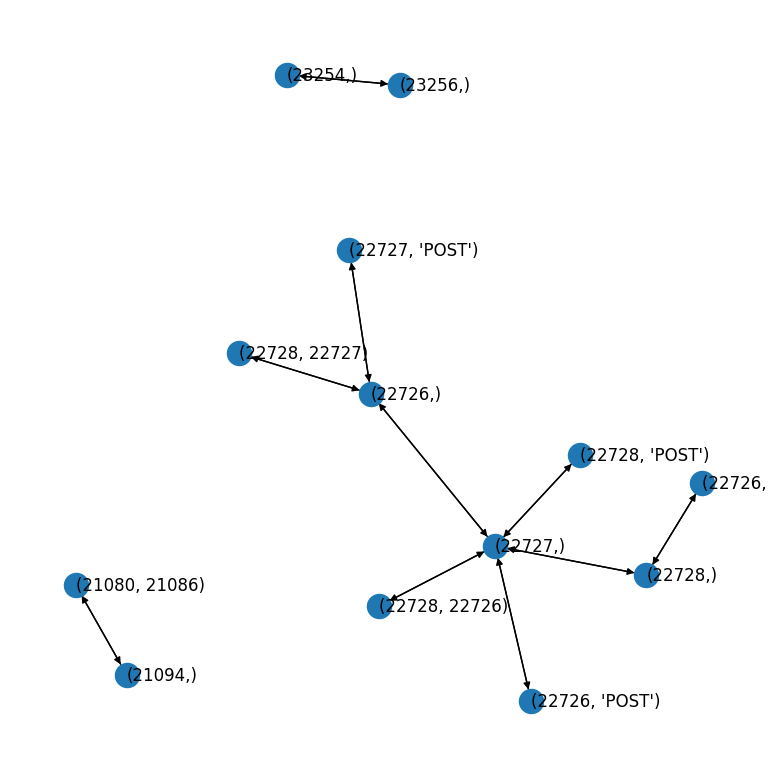

In [36]:
# 그래프 그리기
pos = nx.spring_layout(G, k=0.6, seed=random_seed)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,
    horizontalalignment='left',
    verticalalignment='center')
plt.axis('off')
plt.tight_layout()
plt.show()

해당 자료를 살펴보면 규칙에 대한 그래프를 보게되어서 조금더 쉽게 현상에 대해 파악할 수 있습니다.

연관분석의 경우 많은 패턴이 중복적으로 연결되어있기 때문에 결과 정리할때 중복을 고려하셔야 합니다.